In [1]:
import pandas as pd
import numpy as np

from scipy import signal
from scipy import fftpack

import matplotlib.pyplot as plt
import plotly.express as px
from pylab import rcParams

import datetime
import os
import re
import glob
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
path = '../../output/1_波浪/water_level/*.csv'
filelist = glob.glob(path)
filelist.sort()

In [3]:
df = pd.read_csv(filelist[0])

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')

df['date'] = df['datetime'].apply(lambda x: str(x.year) + '-' + str(x.month) + '-' + str(x.day))
df['date'] = pd.to_datetime(df['date'])

In [135]:
# 10日分全部描画
# 波形(x, y)からn個のピークを幅wで検出する関数(xは0から始まる仕様）
# def findpeaks(x, y, n, w):
#     index_all = list(signal.argrelmax(y, order=w))                  # scipyのピーク検出
#     index = []                                                      # ピーク指標の空リスト
#     peaks = []                                                      # ピーク値の空リスト
 
#     # n個分のピーク情報(指標、値）を格納
#     for i in range(n):
#         index.append(index_all[0][i])
#         peaks.append(y[index_all[0][i]])
#     index = np.array(index) * x[1]                                  # xの分解能x[1]をかけて指標を物理軸に変換
#     return index, peaks

In [2]:
# 24時間フレーム数は172800
# 必要な２０分フレームは2400  1時間が7200


n_frame = 43200 # 6時間ごと
time_step = 0.5
cols = 2

# 電中研資料との比較のため、とりあえず6時間ごとデータのスペクトルで比較
for i in range(len(filelist)):
#for i in range(1):
    print(i, ' : ', filelist[i])
    df = pd.read_csv(filelist[i])
    fig, axes = plt.subplots(4, cols, figsize=(12,20))
    
    
    for j in range(4):
        
        df_split = df.iloc[(n_frame * j):(n_frame * (j+1)),:].reset_index(drop=True)
        
        df_split['datetime'] = pd.to_datetime(df_split['datetime'], format='%Y-%m-%d')
        df_split['date'] = df_split['datetime'].apply(lambda x: str(x.year) + '-' + \
                                                      str(x.month) + '-' + \
                                                      str(x.day) + ' ' + \
                                                      str(x.hour) + ':' + \
                                                      str(x.minute))
        # グラフ名用に日付抽出
        date = df_split['datetime'].apply(lambda x: str(x.year) + '-' + \
                                                      str(x.month) + '-' + \
                                                      str(x.day))[0]
        
        date_time = str(df_split['date'][0])
        
        
        df_split['date'] = pd.to_datetime(df_split['date'])
        
        #FFT
        sample_freq = fftpack.fftfreq(len(df_split), d=time_step)  # 周波数軸を生成
        y_fft = fftpack.fft(df_split['water_level'])/(n_frame/2)  # フーリエスペクトル（複素数）
        pidxs = np.where(sample_freq > 0)
        

        freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs] 
        mfreq = freqs[500:20000][power[500:20000].argmax()] # ピーク周波数
        mpower_index = power[freqs == mfreq]
       
        row = j

        axes[row, 0].plot( df_split['datetime'], df_split['water_level'],'b-', linewidth=1)
        axes[row, 0].set_xlabel('Time')
        axes[row, 0].set_ylabel('Water Level [cm]')
        axes[row, 0].tick_params(axis ='x', rotation = 45)
        axes[row, 0].set_title(date_time + '\n' + 'Org Time-Series')
        axes[row, 0].grid(True)

        #plt.semilogx(freqs, power,'b.-',lw=1)
        axes[row, 1].loglog(freqs, power,'b.-',lw=1)
        axes[row, 1].loglog(mfreq, mpower_index, 'b.-', color='red')
        axes[row, 1].set_title(date_time + '\n' + 'Spectral Analysis' + '\n' + \
                               'Peak Freq : ' + str(np.round(mfreq, 4)) + '[Hz]' + \
                               '   Peak Cycle T : ' + str(np.round(1 / mfreq, 4)) + '[s]')
        axes[row, 1].set_xlabel('Frequency')
        axes[row, 1].set_ylabel('Power')
        axes[row, 1].grid(True)

        plt.tight_layout()
        print(i, '-', j, ' : fin')
        plt.savefig('../../output/1_波浪/figure/' + date + '.png')
    



NameError: name 'filelist' is not defined

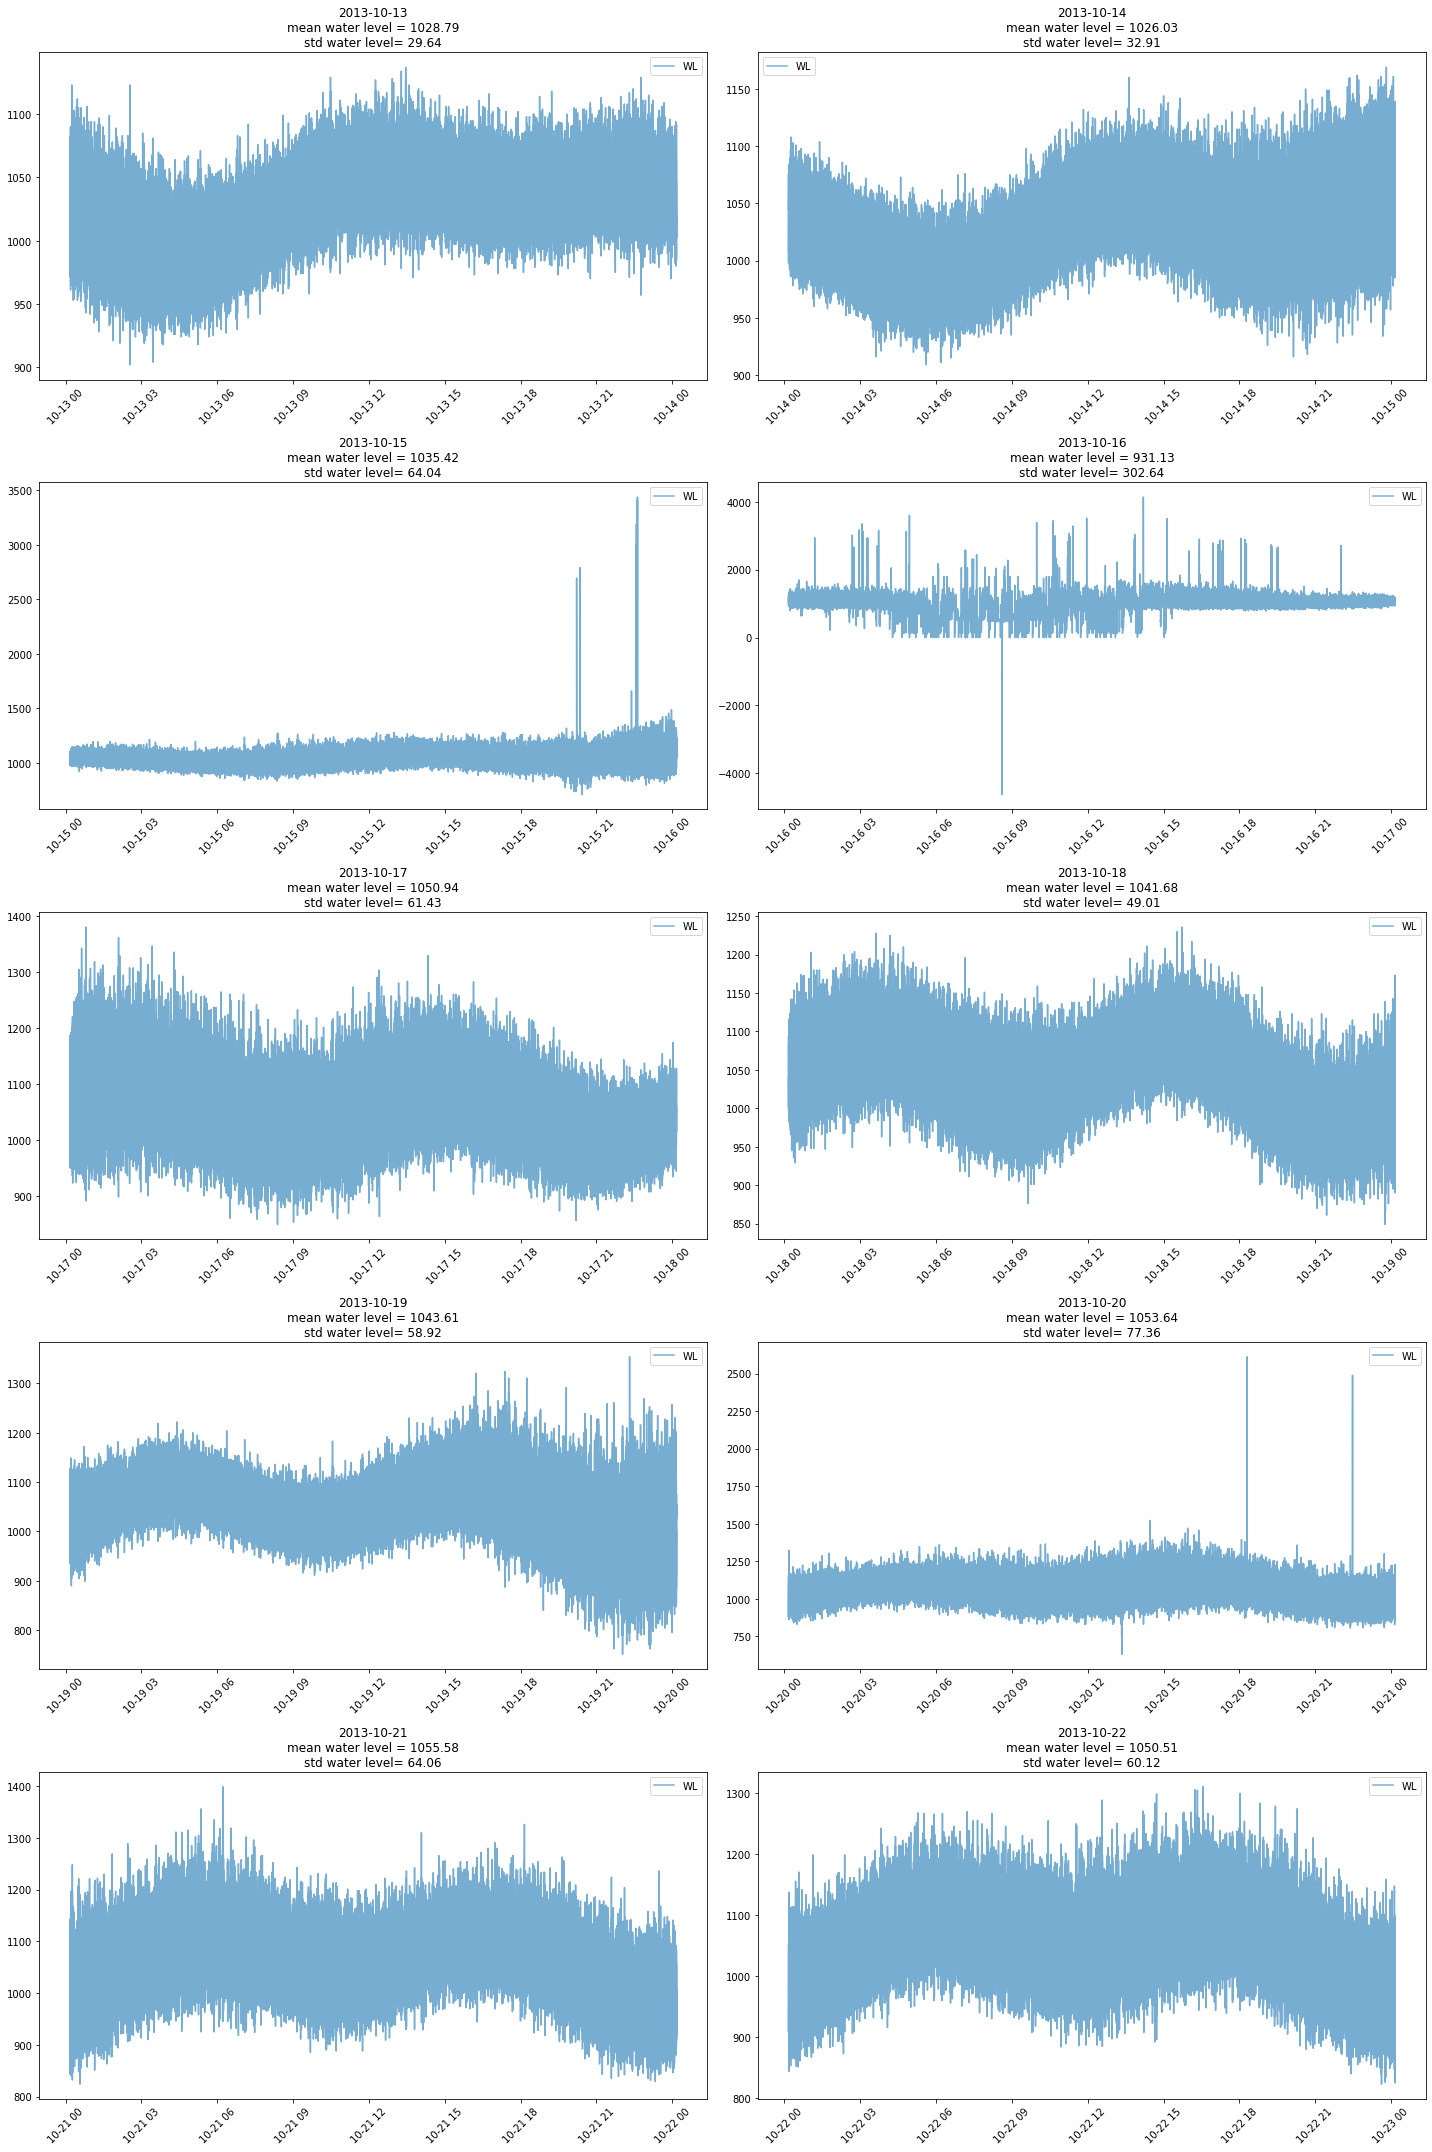

In [7]:
rcParams['figure.figsize'] = 20, 3 * len(filelist)
cols = 2

# df_all = pd.DataFrame()
# for i, file in enumerate(filelist):
#     df_temp = pd.read_csv(file) 
#     df_all = pd.concat([df_all, df_Temp], axis=1)

fig, axes = plt.subplots(len(filelist) // cols, cols)

for i, file in enumerate(filelist):

    df_temp = pd.read_csv(file)
    df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])
    title = re.search('\d{4}-\d{2}-\d{2}', file).group()
   
    
    col = i % cols 
    row = i // cols
    
#     axes0 = axes[0, 0].twinx()
#     axes2 = axes[row, col].twinx()
#     axes[row, col].set_ylim(-500, 4000)
#     axes2.set_ylim(-400, 400)
#     axes[row, col].get_shared_y_axes().join(axes2, axes0)
    
#     axes2.plot(df_temp['datetime'], df_temp['E_cmpersec'], label = 'E', color = 'red', alpha = 0.6)
#     axes2.plot(df_temp['datetime'], df_temp['N_cmpersec'], label = 'N', color = 'green', alpha = 0.6)
    axes[row, col].plot(df_temp['datetime'], df_temp['water_level'], label = 'WL', alpha = 0.6)
    axes[row, col].set_title(title + '\n' + 'mean water level = ' + str(round(df_temp['water_level'].mean(), 2)) \
                             + '\n' + 'std water level= ' + str(round(df_temp['water_level'].std(), 2)))
    axes[row, col].tick_params(axis ='x', rotation = 45)
    axes[row, col].legend()
#     h1, l1 = axes[row, col].get_legend_handles_labels()
#     h2, l2 = axes2.get_legend_handles_labels()
#     axes[row, col].legend(h1+h2, l1+l2, loc='upper right')
    plt.tight_layout()
    
plt.show()
    

Text(0.5, 1.0, 'Water Level[cm] : from 2021-10-13 to 10-22')

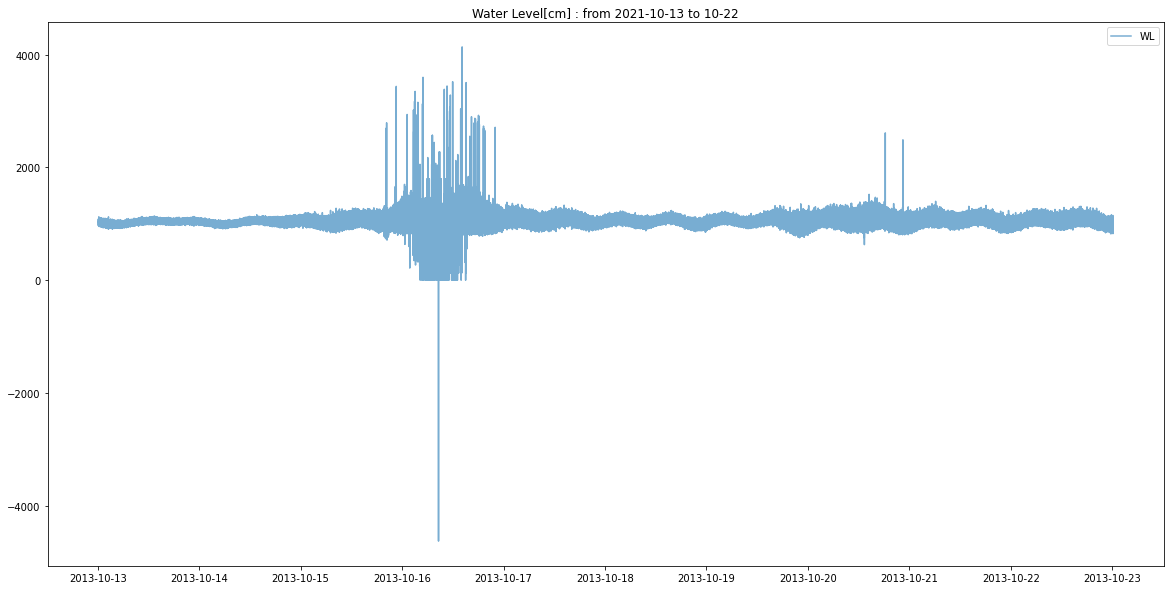

In [7]:
rcParams['figure.figsize'] = 20, 10
df_all = pd.DataFrame()

for i, file in enumerate(filelist[0:10]):
    
    df_temp = pd.read_csv(file)
    df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])
    df_all = pd.concat([df_all, df_temp], axis=0).reset_index(drop=True)
    
plt.plot(df_all['datetime'], df_all['water_level'], label = 'WL', alpha = 0.6)
plt.legend()
plt.title('Water Level[cm] : from 2021-10-13 to 10-22')

In [16]:
df_all.shape

(1728000, 5)

In [9]:
# fig = px.line(df_all, x='datetime', y='water_level', title='Water Level[cm] : from 2021-10-13 to 10-22')
# fig.show()

In [86]:
10*60*60*24*2

1728000

In [87]:
4320/24/60

3.0

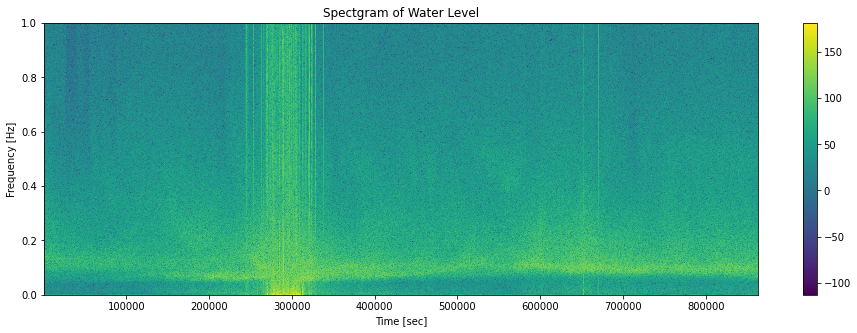

In [88]:
rcParams['figure.figsize'] = 16, 5
fs = 2 # サンプリング周波数
f, t, Sxx = signal.spectrogram(df_all['water_level'],
                               fs,
                               window=('hanning'), 
                               nperseg=2400,
                               noverlap=1200)

pcm = plt.pcolormesh(t, 
                     f, 
                     #10*np.log(np.abs(Sxx)),  #intensityをdB修正
                     10*np.log(np.abs(Sxx)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectgram of Water Level')
cbar = plt.colorbar() #カラーバー表示のため追加
# cbar.ax.set_ylabel("Intensity [dB]") #カラーバーの名称表示のため追加
# fig.colorbar(pcm, ax=pcm.axes, shrink=0.6)

In [24]:
len(t)

1439

In [25]:
len(f)

1201

In [26]:
Sxx.shape

(1201, 1439)

In [39]:
Sxx.T.shape

(1439, 1201)

In [47]:
np.argmax(Sxx[1, 0])

0

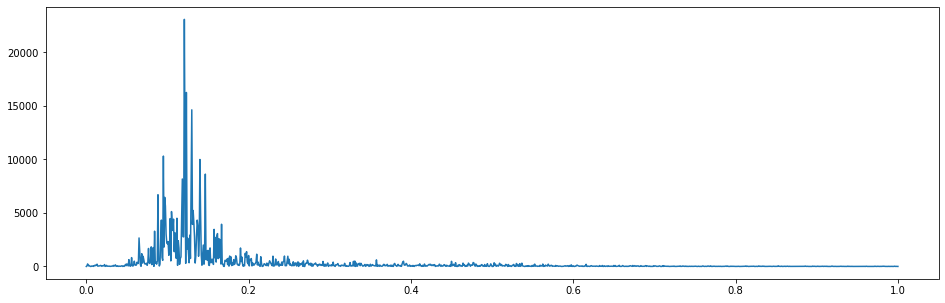

In [71]:
plt.plot(f, Sxx.T[101, :])

In [83]:
1 / f[np.argmax(Sxx.T[107, :])]

8.053691275167784

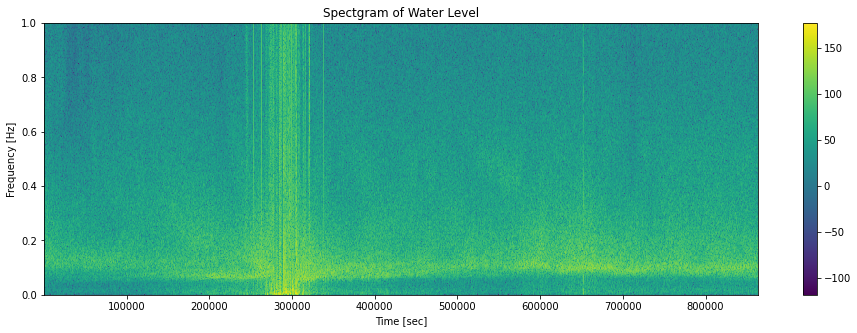

In [89]:
rcParams['figure.figsize'] = 16, 5

# 10日間が1728000コマ
# nperseg = 600（５分）、overlap = 200で　短時間フーリエ変換　→　トータル4320コマ
# 10日分が4320コマ　→　1分あたりのコマ数（4320 / 10日 / 24時間 / 60分 ）* 10分　→　１０分分が３コマのデータになる
# 変換後のマックスのスペクトル周波数を3コマ分の平均値でならす

fs = 2 # サンプリング周波数
f, t, Sxx = signal.spectrogram(df_all['water_level'],
                               fs,
                               window=('hanning'),
                               nperseg=600, # 5分
                               noverlap=200) # 200コマオーバーラップ

pcm = plt.pcolormesh(t, 
                     f, 
                     #10*np.log(np.abs(Sxx)),  #intensityをdB修正
                     10*np.log(np.abs(Sxx)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectgram of Water Level')
cbar = plt.colorbar() #カラーバー表示のため追加
# cbar.ax.set_ylabel("Intensity [dB]") #カラーバーの名称表示のため追加
# fig.colorbar(pcm, ax=pcm.axes, shrink=0.6)

In [85]:
len(t)

4319

In [91]:
peak_freq = list()
for i in range(len(Sxx.T)):
    peak_freq.append(f[np.argmax(Sxx.T[i, :])])

In [93]:
len(peak_freq)

4319

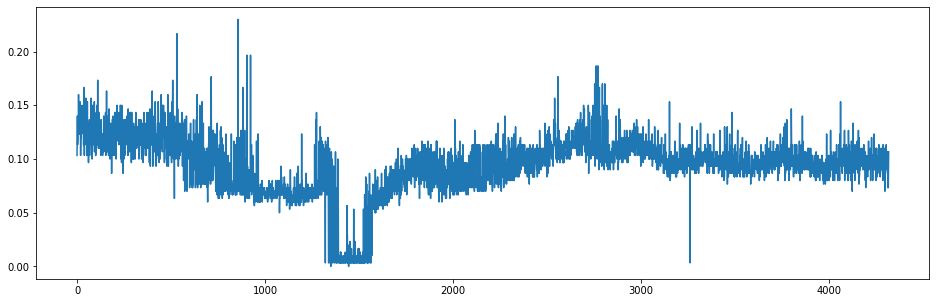

In [102]:
plt.plot( peak_freq)

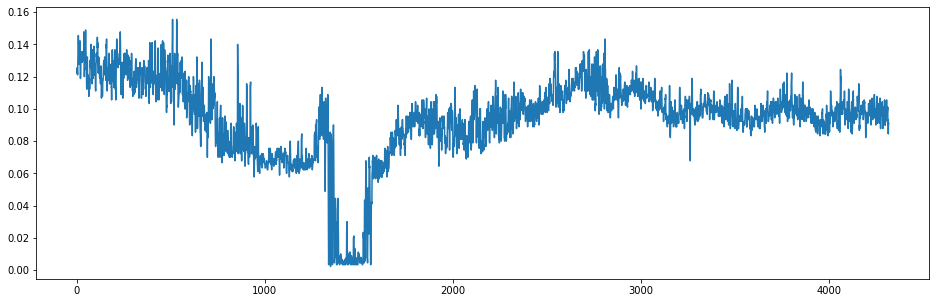

In [99]:
plt.plot(pd.Series(peak_freq).rolling(3, center=True).agg(np.mean))

In [ ]:
rolling()

(0.0, 2.0)

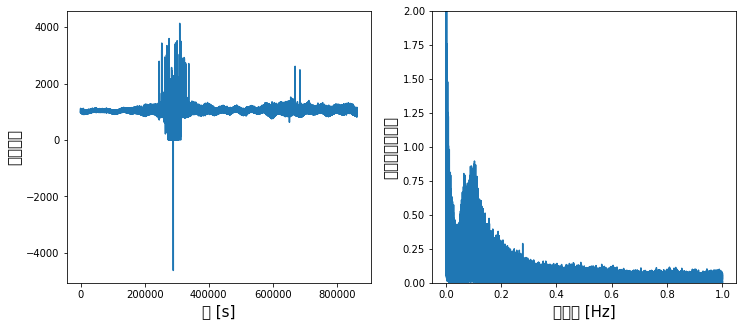

In [23]:
# データのパラメータ
N = len(df_all)             # サンプル数
dt = 0.5          # サンプリング間隔
#f1, f2 = 10, 40    # 周波数
t = np.arange(0, N*dt, dt) # 時間軸
freq = np.linspace(0, 1.0/dt, N) # 周波数軸
 
# 信号を生成（周波数f1の正弦波+周波数f2の正弦波）
signal = df_all['water_level']
 
# グラフ表示
fig = plt.figure(figsize=(12, 5))
 
# 左の図
ax1 = fig.add_subplot(121)
plt.plot(t, signal)
plt.xlabel("秒 [s]", fontsize=15)
plt.ylabel("シグナル", fontsize=15)
 
# 高速フーリエ変換(FFT)
F = np.fft.fft(signal)
# 振幅スペクトルを計算
amplitude = np.abs(F)
 
# 調整
F_amplitude = amplitude / N * 2
F_amplitude[0] = F_amplitude[0] / 2
 
# 右の図
ax2 = fig.add_subplot(122)
plt.plot(freq[:int(N/2)+1], F_amplitude[:int(N/2)+1])
plt.xlabel("周波数 [Hz]", fontsize=15)
plt.ylabel("振幅スペクトル", fontsize=15)
plt.ylim(0, 2)

In [13]:
def f(x):
    pi2 = 2.*np.pi
    return 1.0*np.sin(0.1*pi2*x) + 1.0*np.cos(1.*pi2*x)

#Periodic data with/without random noise
xdata = np.linspace(0, 100, num=1024)
np.random.seed(1234)
ydata = f(xdata) #+ 10.*np.random.randn(xdata.size)

time_step = xdata[1]-xdata[0]

In [16]:
ydata[:].size

1024

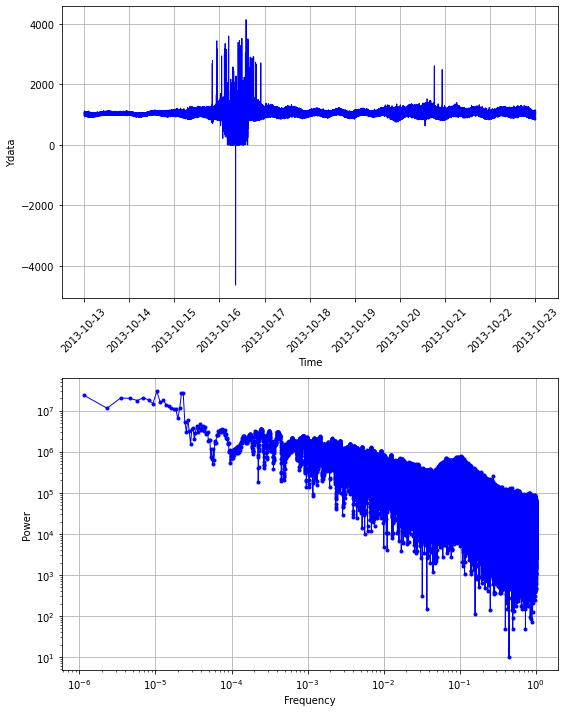

In [20]:
time_step = 0.5


#FFT
sample_freq = fftpack.fftfreq(len(df_all), d=time_step)
y_fft = fftpack.fft(df_all['water_level'])
pidxs = np.where(sample_freq > 0)
freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs]
freq = freqs[power.argmax()]

#PLot
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(df_all['datetime'],df_all['water_level'],'b-', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Ydata')
plt.tick_params(axis ='x', rotation = 45)
plt.grid(True)

plt.subplot(212)
#plt.semilogx(freqs, power,'b.-',lw=1)
plt.loglog(freqs, power,'b.-',lw=1)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)

plt.tight_layout()

plt.show()

In [5]:
864000/60/60

240.0